### combine and plot stacked results from different dates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import pandas as pd
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
#path = '/Users/jpw/Analysis/NIRSPEC/iSHELL/spectroastrometry/RESULTS/'
source = 'HLTau'
PA1 = 138
PA2 = PA1 + 180
trans = 'lowJ'
dates = ['191008', '200220', '240106']

PA1 = 48
PA2 = PA1 + 180
trans = 'lowJ'
dates = ['240106', '240107']

In [3]:
# read in the first date and use this to define the velocity axis
filename = str(f'{source}_stacked_{dates[0]}_PA{PA1}_{PA2}_{trans}.csv')
df = pd.read_csv(filename, comment='#')

# remove spaces from column names that came from stack.ipynb    
df.columns = df.columns.str.replace(' ', '')

# handle the NaN and Inf in the flux and SA columns
fix_columns = ['flux', 'err_flux', 'SA', 'err_SA']
for c in fix_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

v0 = df['Vhelio']
flux0 = df['flux']
err_flux0 = df['err_flux']
SA0 = df['SA']
err_SA0 = df['err_SA']

In [4]:
# add two arrays with "and" (instead of standard "or") logic on nan
def add_ignore_nan(x, y):
    z = []
    for i in range(x.size):
        x1 = x[i]
        y1 = y[i]
        if np.isfinite(x1) or np.isfinite(y1):
            z.append(np.nansum([x1, y1]))
        else:
            z.append(np.nan)
    return np.array(z)

In [6]:
# add the other dates to it, weighting by 1/error^2 as error is the standard deviation (unlike the variance in the rectified images earlier in the pipeline)
flux_c = flux0/err_flux0**2
w_flux_c = 1/err_flux0**2
SA_c = SA0/err_SA0**2
w_SA_c = 1/err_SA0**2

for date in dates[1:]:
    f1 = str(f'{source}_stacked_{date}_PA{PA1}_{PA2}_{trans}.csv')
    df1 = pd.read_csv(f1, comment='#')
    df1.columns = df1.columns.str.replace(' ', '')
    df1['SA'] = pd.to_numeric(df1['SA'], errors='coerce')
    df1['err_SA'] = pd.to_numeric(df1['err_SA'], errors='coerce')

    v1 = df1['Vhelio']
    flux1 = interp1d(v1, df1['flux'], bounds_error=False)(v0)
    err_flux1 = interp1d(v1, df1['err_flux'], bounds_error=False)(v0)
    SA1 = interp1d(v1, df1['SA'], bounds_error=False)(v0)
    err_SA1 = interp1d(v1, df1['err_SA'], bounds_error=False)(v0)
    
    flux_c = add_ignore_nan(flux_c, flux1/err_flux1**2)
    w_flux_c = add_ignore_nan(w_flux_c, 1/err_flux1**2)
    SA_c = add_ignore_nan(SA_c, SA1/err_SA1**2)
    w_SA_c = add_ignore_nan(w_SA_c, 1/err_SA1**2)

n = len(dates)
flux_c /= w_flux_c
SA_c /= w_SA_c
err_flux_c = np.sqrt(n/w_flux_c)
err_SA_c = np.sqrt(n/w_SA_c)

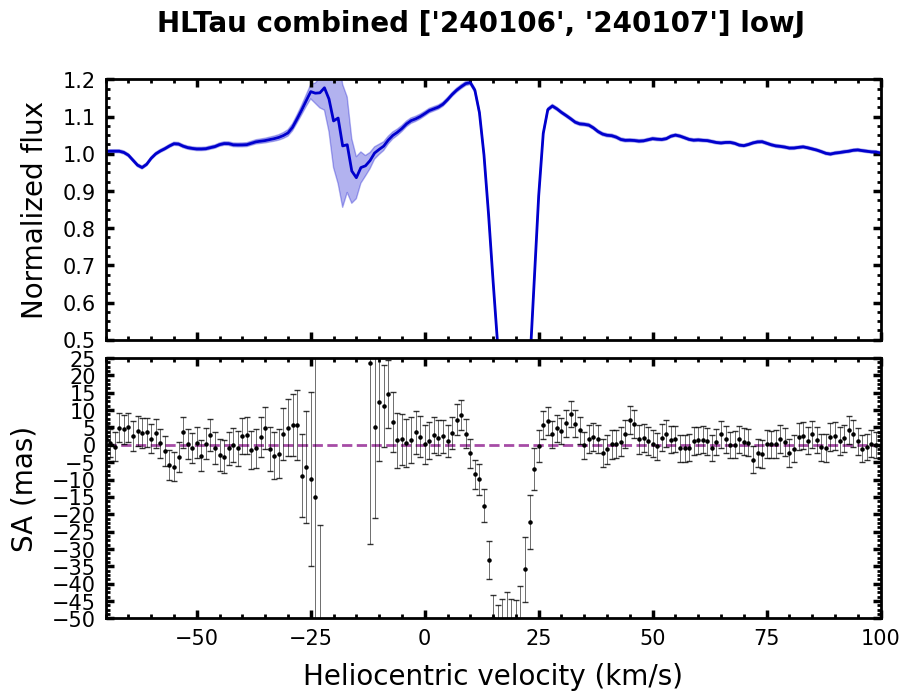

In [12]:
fig = plt.figure(figsize=(10, 7))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.07)
ax1 = fig.add_subplot(211)
ax1.plot(v0, flux_c, color='mediumblue', lw=2)
ax1.fill_between(v0, flux_c-err_flux_c, flux_c+err_flux_c, color='mediumblue', alpha=0.3)

ax2 = fig.add_subplot(212)
ax2.scatter(v0, SA_c, color='k', s=5)
ax2.errorbar(v0, SA_c, err_SA_c, color='k', alpha=0.8, lw=0.5, capsize=2, linestyle=' ')
ax2.axhline(0, color='purple', ls = '--', lw=2, zorder=0, alpha=0.7)

for ax in [ax1,ax2]:
    ax.set_xlim(-70, 100)
    index_xticks = 25
    ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
    ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))
    ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=15, pad=7, width=2.5, length=6,direction='in',color='k')
    ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=15, pad=7, width=2, length=3,direction='in',color='k')
    
ax1.set_ylim(0.0, 1.5)
ax1.set_ylim(0.5, 1.2)
index_yticks1 = 0.1 
ax1.yaxis.set_major_locator(MultipleLocator(index_yticks1))
ax1.yaxis.set_minor_locator(MultipleLocator(index_yticks1/4))

ax2.set_ylim(-50, 25)
index_yticks2 = 5
ax2.yaxis.set_major_locator(MultipleLocator(index_yticks2))
ax2.yaxis.set_minor_locator(MultipleLocator(index_yticks2/4))

ax1.set_xticklabels([])
ax2.set_xlabel('Heliocentric velocity (km/s)', labelpad=10, fontsize=20)
ax1.set_ylabel('Normalized flux', labelpad=10, fontsize=20)
ax2.set_ylabel('SA (mas)', labelpad=10, fontsize=20)

for side in ax1.spines.keys():  # 'top'
        ax1.spines[side].set_linewidth(2)
for side in ax2.spines.keys():  # 'top'
        ax2.spines[side].set_linewidth(2)
        
plt.suptitle(f'{source} combined {dates} {trans}', fontsize=20, fontweight='bold')
plt.savefig(f'{source}_combined_stacked_PA{PA1}_{PA2}_{trans}.png', bbox_inches='tight')

In [8]:
print('Saving combined spectrum and SA signal')
csvfile = open(f'{source}_combined_stacked_PA{PA1}_{PA2}_{trans}.csv', 'w')
csvfile.write(f'# Combination of {trans} over dates {dates}\n')
csvfile.write(' Vhelio,      flux,  err_flux,          SA,   err_SA\n')
for i in range(v0.size):
    csvfile.write(f'{v0[i]:7.2f}, {flux_c[i]:9.4f}, {err_flux_c[i]:9.4f},    {SA_c[i]:8.3f}, {err_SA_c[i]:8.3f}\n')   
csvfile.close()

Saving combined spectrum and SA signal
